In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jeju-dataset/submission.csv
/kaggle/input/jeju-dataset/201901-202003.csv


# ▶ 해결해야 하는 문제
- 2020.04, 2020.07 기간 내 (지역,업종) 별 (월간 총 사용 금액) 예측


- 1. 201901-202003.csv (2.07 GB)
- 2019.01 ~ 2020.03 기간 내 카드 데이터


- 2. 202004.csv (116 MB)
- 2020.04 기간 내 카드 데이터 (7/28 공개)

# 평가지표
- RMSLE (Root Mean Square Logarithmic Error) 
- 제주 지역에 3배 가중치 부여

In [2]:
# REG_YYMM : 년월
# 카드이용지역_시도 (가맹점 주소 기준) 
# 카드이용지역_시군구 (가맹점 주소 기준)  
# 업종명 
# 거주지역_시도 (고객 집주소 기준) 
# 거주지역_시군구 (고객 집주소 기준) 
# 연령 
# 성별 
# FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
# CSTNR_CNT : 이용고객수 (명)  
# AMT : 이용금액 (원)  
# CNT : 이용건수 (건)  

In [3]:
train = pd.read_csv("/kaggle/input/jeju-dataset/201901-202003.csv")
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [4]:
# 날짜(REG_YYMM) 전처리
train["year"] = np.floor(train["REG_YYMM"]/100).astype(int)
train["month"] = np.floor(train["REG_YYMM"]%100).astype(int)

train = train.drop(["REG_YYMM"], axis = 1)
train

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24697787,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,3,43300,4,2020,3
24697788,충북,충주시,휴양콘도 운영업,충북,충주시,40s,1,3,3,35000,3,2020,3
24697789,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,4,188000,6,2020,3
24697790,충북,충주시,휴양콘도 운영업,충북,충주시,50s,2,4,4,99000,6,2020,3


In [5]:
# train.isna().sum()

# 총 데이터
# train         24697792

# 결측치(시군구)
# CARD_CCG_NM      87213
# HOM_CCG_NM      147787

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for i in train.columns[train.dtypes == object]:
    
    train[i] = le.fit_transform(list(train[i]))

train.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,0,4,0,0,4,1,1,1,4,311200,4,2019,1
1,0,4,0,0,4,2,1,2,7,1374500,8,2019,1
2,0,4,0,0,4,2,2,2,6,818700,6,2019,1
3,0,4,0,0,4,3,1,3,4,1717000,5,2019,1
4,0,4,0,0,4,3,1,4,3,1047300,3,2019,1


In [7]:
# 데이터 재구성

from itertools import product

matrix = []

for i in range(1):
    matrix.append(np.array(list(product(train["year"].unique(), train["month"].unique(),train["CARD_SIDO_NM"].unique(), train["STD_CLSS_NM"].unique() )), dtype = np.int16)) 

matrix = pd.DataFrame(np.vstack(matrix))
matrix.columns = ["year","month","CARD_SIDO_NM","STD_CLSS_NM"]


# 2019.01 ~ 2020.04월,07월 까지만
matrix = matrix.drop(matrix[(matrix["year"]==2020) & (matrix["month"] > 7)].index)
matrix = matrix.drop(matrix[(matrix["month"] == 5) | (matrix["month"] == 6)].index)

matrix = matrix.reset_index().drop(["index"], axis=1) # 인덱스 정리
matrix

,year,month,CARD_SIDO_NM,STD_CLSS_NM
0,2019,1,0,0
1,2019,1,0,1
2,2019,1,0,2
3,2019,1,0,3
4,2019,1,0,5
...,...,...,...,...
10450,2020,7,16,35
10451,2020,7,16,8
10452,2020,7,16,12
10453,2020,7,16,4


In [8]:
# 매 달 지역별 업종의 총 이용금액의 합
AMT_sum = train.groupby(['year',"month", 'CARD_SIDO_NM', 'STD_CLSS_NM'])["AMT"].sum().reset_index()
AMT_sum

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,2019,1,0,0,148354746
1,2019,1,0,1,1229200312
2,2019,1,0,2,1286979106
3,2019,1,0,3,30656770
4,2019,1,0,5,13101500
...,...,...,...,...,...
9433,2020,3,16,36,1315245299
9434,2020,3,16,37,16152482704
9435,2020,3,16,38,15248550
9436,2020,3,16,39,428881434


In [9]:
matrix2 = pd.merge(matrix,AMT_sum,on=["year","month","CARD_SIDO_NM","STD_CLSS_NM"], how="left")
matrix2

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,2019,1,0,0,1.483547e+08
1,2019,1,0,1,1.229200e+09
2,2019,1,0,2,1.286979e+09
3,2019,1,0,3,3.065677e+07
4,2019,1,0,5,1.310150e+07
...,...,...,...,...,...
10450,2020,7,16,35,NaN
10451,2020,7,16,8,NaN
10452,2020,7,16,12,NaN
10453,2020,7,16,4,NaN


In [10]:
# 추가 결측치

matrix2[(matrix2["year"] == 2020) & (matrix2["month"] == 3) & (matrix2["CARD_SIDO_NM"] == 16)].tail(10)

# 4,12,14,15,23,28,30의 7개 업종의 추가 결측치

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
9051,2020,3,16,40,12733490.0
9052,2020,3,16,23,NaN
9053,2020,3,16,28,NaN
9054,2020,3,16,14,NaN
9055,2020,3,16,15,NaN
9056,2020,3,16,35,993360.0
9057,2020,3,16,8,942000.0
9058,2020,3,16,12,NaN
9059,2020,3,16,4,NaN
9060,2020,3,16,30,NaN


In [11]:
# 결측치 처리 -> 이용내역이 없음 -> 0으로 채움
matrix2 = matrix2.fillna(0)
matrix2[(matrix2["year"] == 2020) & (matrix2["month"] == 3) & (matrix2["CARD_SIDO_NM"] == 16)].tail(10)

,year,month,CARD_SIDO_NM,STD_CLSS_NM,AMT
9051,2020,3,16,40,12733490.0
9052,2020,3,16,23,0.0
9053,2020,3,16,28,0.0
9054,2020,3,16,14,0.0
9055,2020,3,16,15,0.0
9056,2020,3,16,35,993360.0
9057,2020,3,16,8,942000.0
9058,2020,3,16,12,0.0
9059,2020,3,16,4,0.0
9060,2020,3,16,30,0.0


In [12]:
# train, test set나누기

# 2020.02까지 index는 9060

x_train = matrix2.iloc[:9061,:].drop(["AMT"], axis=1)  # ~ 2020.03월 까지의 총 사용금액 데이터 
y_train = pd.DataFrame(matrix2.iloc[:9061,:]["AMT"])

x_valid = matrix2.iloc[9061:,:].drop(["AMT"], axis=1)  # ~ 2020.04,07월의 업종과 위치정보 데이터
y_valid = pd.DataFrame(matrix2.iloc[9061:,:]["AMT"])

# 시각화

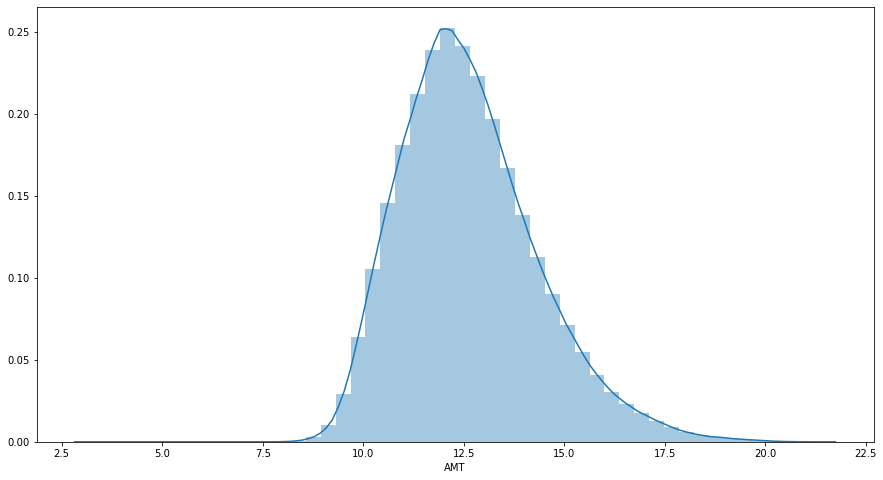

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))

#sns.boxplot(train["month"],train["AMT"] )
sns.distplot(np.log(train["AMT"]))

In [19]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(n_estimators = 1000)
cat.fit(x_train,y_train)
result = cat.predict(x_valid)

# from lightgbm import LGBMRegressor
# lgb = LGBMRegressor(n_estimators = 1000)
# lgb.fit(x_train,y_train, eval_set = (x_valid, y_valid), early_stopping_rounds = 15)
# result = lgb.predict(test)

# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor()
# rf.fit(x_train,y_train)
# result = rf.predict(x_valid)

Learning rate set to 0.05778
0:	learn: 17560109722.4272842	total: 2.85ms	remaining: 2.85s
1:	learn: 17175875798.1859570	total: 5.57ms	remaining: 2.78s
2:	learn: 16800855350.1356049	total: 7.74ms	remaining: 2.57s
3:	learn: 16456536442.4082642	total: 9.82ms	remaining: 2.44s
4:	learn: 16153178849.8380718	total: 12.5ms	remaining: 2.48s
5:	learn: 15803948327.0095043	total: 14.6ms	remaining: 2.42s
6:	learn: 15482910082.5775528	total: 16.7ms	remaining: 2.36s
7:	learn: 15224647315.7322273	total: 18.9ms	remaining: 2.34s
8:	learn: 14938617038.2110291	total: 21.1ms	remaining: 2.32s
9:	learn: 14707303518.1802979	total: 23.2ms	remaining: 2.3s
10:	learn: 14462327998.3759384	total: 25.4ms	remaining: 2.28s
11:	learn: 14250736675.6543922	total: 27.4ms	remaining: 2.26s
12:	learn: 14057909018.5476723	total: 29.6ms	remaining: 2.25s
13:	learn: 13845579220.8258476	total: 32.1ms	remaining: 2.26s
14:	learn: 13684357185.5037785	total: 34.2ms	remaining: 2.25s
15:	learn: 13503969331.8660965	total: 36.7ms	remaini

165:	learn: 5632173133.0705299	total: 380ms	remaining: 1.91s
166:	learn: 5612921515.5379095	total: 383ms	remaining: 1.91s
167:	learn: 5593075368.3791304	total: 385ms	remaining: 1.91s
168:	learn: 5586676694.3326178	total: 387ms	remaining: 1.9s
169:	learn: 5562305429.3740673	total: 389ms	remaining: 1.9s
170:	learn: 5540743042.5296307	total: 392ms	remaining: 1.9s
171:	learn: 5527754783.9755077	total: 394ms	remaining: 1.9s
172:	learn: 5509246792.7278671	total: 396ms	remaining: 1.89s
173:	learn: 5491342290.8147926	total: 398ms	remaining: 1.89s
174:	learn: 5453906257.0467386	total: 401ms	remaining: 1.89s
175:	learn: 5437231007.4439344	total: 403ms	remaining: 1.89s
176:	learn: 5429137062.9498167	total: 406ms	remaining: 1.89s
177:	learn: 5413693799.1942368	total: 408ms	remaining: 1.88s
178:	learn: 5393096167.4247046	total: 410ms	remaining: 1.88s
179:	learn: 5372550243.4275999	total: 412ms	remaining: 1.88s
180:	learn: 5353980917.5814247	total: 415ms	remaining: 1.88s
181:	learn: 5342065107.59109

335:	learn: 3983048331.5162210	total: 768ms	remaining: 1.52s
336:	learn: 3981260922.2082086	total: 771ms	remaining: 1.52s
337:	learn: 3977176883.7222743	total: 773ms	remaining: 1.51s
338:	learn: 3973401139.1585975	total: 775ms	remaining: 1.51s
339:	learn: 3969572545.5243011	total: 777ms	remaining: 1.51s
340:	learn: 3959901357.6216631	total: 779ms	remaining: 1.51s
341:	learn: 3955701368.6167817	total: 782ms	remaining: 1.5s
342:	learn: 3949546347.8400521	total: 784ms	remaining: 1.5s
343:	learn: 3942635295.0683570	total: 786ms	remaining: 1.5s
344:	learn: 3936342037.8855133	total: 788ms	remaining: 1.5s
345:	learn: 3919321658.5715685	total: 791ms	remaining: 1.49s
346:	learn: 3914864453.2537689	total: 793ms	remaining: 1.49s
347:	learn: 3913198788.7279644	total: 795ms	remaining: 1.49s
348:	learn: 3907966371.5997972	total: 797ms	remaining: 1.49s
349:	learn: 3905326767.4734888	total: 799ms	remaining: 1.48s
350:	learn: 3895766054.3025136	total: 802ms	remaining: 1.48s
351:	learn: 3892080509.86348

507:	learn: 3143228453.1650705	total: 1.15s	remaining: 1.12s
508:	learn: 3141971900.1280689	total: 1.16s	remaining: 1.12s
509:	learn: 3138094722.2259212	total: 1.16s	remaining: 1.11s
510:	learn: 3136960918.6371498	total: 1.16s	remaining: 1.11s
511:	learn: 3130637337.5896382	total: 1.16s	remaining: 1.11s
512:	learn: 3128195072.6643019	total: 1.17s	remaining: 1.11s
513:	learn: 3124785962.9341893	total: 1.17s	remaining: 1.1s
514:	learn: 3120566771.4529943	total: 1.17s	remaining: 1.1s
515:	learn: 3113852607.8483672	total: 1.17s	remaining: 1.1s
516:	learn: 3105403085.8268018	total: 1.18s	remaining: 1.1s
517:	learn: 3097492304.8551002	total: 1.18s	remaining: 1.1s
518:	learn: 3093822675.8358912	total: 1.18s	remaining: 1.09s
519:	learn: 3090982866.6246557	total: 1.18s	remaining: 1.09s
520:	learn: 3089878393.5470419	total: 1.18s	remaining: 1.09s
521:	learn: 3087972648.1491427	total: 1.19s	remaining: 1.09s
522:	learn: 3087194808.4194741	total: 1.19s	remaining: 1.08s
523:	learn: 3084123799.062984

665:	learn: 2687685731.8931499	total: 1.54s	remaining: 772ms
666:	learn: 2686683189.6466599	total: 1.54s	remaining: 771ms
667:	learn: 2682407471.5483518	total: 1.54s	remaining: 768ms
668:	learn: 2676762833.2125759	total: 1.55s	remaining: 766ms
669:	learn: 2675017985.3921862	total: 1.55s	remaining: 764ms
670:	learn: 2671499621.9290657	total: 1.55s	remaining: 761ms
671:	learn: 2669607892.7256269	total: 1.55s	remaining: 759ms
672:	learn: 2665978585.3086901	total: 1.56s	remaining: 757ms
673:	learn: 2664384923.8810019	total: 1.56s	remaining: 754ms
674:	learn: 2660360957.3734097	total: 1.56s	remaining: 752ms
675:	learn: 2658916965.6720519	total: 1.56s	remaining: 750ms
676:	learn: 2656235299.0803380	total: 1.57s	remaining: 747ms
677:	learn: 2654954858.7440791	total: 1.57s	remaining: 745ms
678:	learn: 2653015144.5810604	total: 1.57s	remaining: 743ms
679:	learn: 2652151232.4587579	total: 1.57s	remaining: 740ms
680:	learn: 2651683892.6989398	total: 1.57s	remaining: 738ms
681:	learn: 2649729696.0

829:	learn: 2341622975.2811623	total: 1.92s	remaining: 394ms
830:	learn: 2340834016.8370013	total: 1.93s	remaining: 392ms
831:	learn: 2340358928.7814898	total: 1.93s	remaining: 390ms
832:	learn: 2337713954.6197987	total: 1.93s	remaining: 387ms
833:	learn: 2337337031.7394915	total: 1.94s	remaining: 385ms
834:	learn: 2334863262.1914511	total: 1.94s	remaining: 383ms
835:	learn: 2332142562.8843517	total: 1.94s	remaining: 380ms
836:	learn: 2328607925.1075110	total: 1.94s	remaining: 378ms
837:	learn: 2327489265.2069187	total: 1.94s	remaining: 376ms
838:	learn: 2325906064.7356038	total: 1.95s	remaining: 373ms
839:	learn: 2325107458.2825518	total: 1.95s	remaining: 371ms
840:	learn: 2323815844.1550097	total: 1.95s	remaining: 369ms
841:	learn: 2323528557.1976624	total: 1.95s	remaining: 367ms
842:	learn: 2321988530.3800249	total: 1.96s	remaining: 364ms
843:	learn: 2321728575.7982564	total: 1.96s	remaining: 362ms
844:	learn: 2319231189.3259196	total: 1.96s	remaining: 359ms
845:	learn: 2318196449.1

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:79: At position 0 should be feature with name year (found AMT).

In [ ]:
sub = pd.read_csv("/kaggle/input/jeju-dataset/submission.csv")
sub.head()

In [ ]:
# y_valid = np.abs(y_valid)

In [ ]:
sub["AMT"] = result
sub.head()

In [ ]:
sub.to_csv("jeju.csv",index = False)